In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data,wb
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import quandl as ql
from joblib import Parallel, delayed

In [2]:
S0 = 100
K = 105.
T = 1.
r = 0.05
sigma = 0.2

I = 100000
z = np.random.standard_normal(I)
ST = S0 * np.exp((r - 0.5 * sigma** 2) * T + sigma * np.sqrt(T) * z)

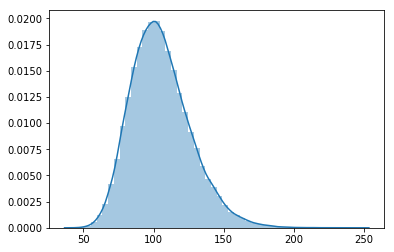

In [3]:
sns.distplot(ST)

In [4]:
hT = np.maximum(ST - K, 0)

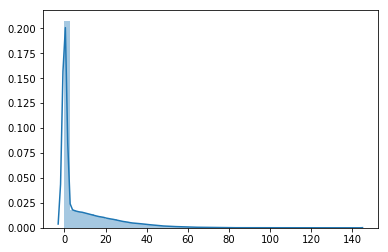

In [5]:
sns.distplot(hT)

In [6]:
C0 = (np.exp(-r*T) * np.sum(hT))/I
print('The price of the European Option is %5.3f' % (C0))

The price of the European Option is 8.110


In [7]:
BTC = ql.get('BCHARTS/BITSTAMPUSD')

In [8]:
BTC['Log_Ret'] = np.log(BTC['Close']/ BTC['Close'].shift(1))

/Users/livingdharma/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


/Users/livingdharma/miniconda2/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


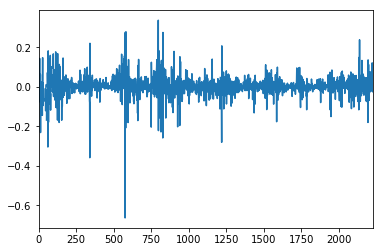

In [9]:
sns.tsplot(data=BTC['Log_Ret'])

In [10]:
BTC['Volatility'] = BTC['Log_Ret'].rolling(window=252).std() * np.sqrt(252)

In [11]:
BTC['Volatility'].tail()


Date
2017-10-16    0.731057
2017-10-17    0.731506
2017-10-18    0.731515
2017-10-19    0.728272
2017-10-20    0.729537
Name: Volatility, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112e68790>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118544c10>], dtype=object)

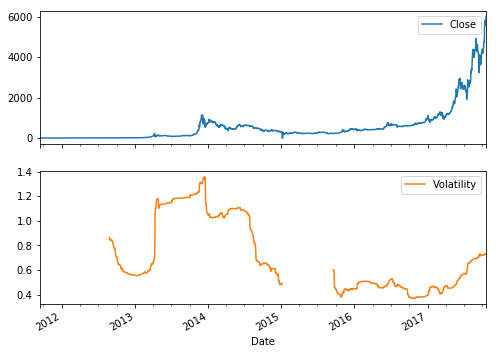

In [12]:
BTC[['Close', 'Volatility']].plot(subplots=True, figsize=(8,6))

In [13]:
VSTOX = ql.get('CHRIS/EUREX_FVS1')

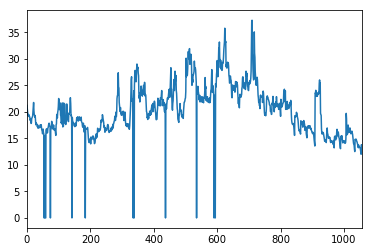

In [14]:
sns.tsplot(VSTOX['Open'], legend=True);

In [15]:
h5 = pd.HDFStore('data/vstoxx_data_31032014.h5')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

In [16]:
v0 = 17.6449
r = 0.01
tol = 0.5

In [17]:
options_data['IMP_VOL'] = 0

In [18]:
from financial_methods import *

In [19]:
       
def compute_imp_vol(option):
    strike = options_data.loc[option]['STRIKE']
    TTM = options_data.loc[option]['TTM']
    price = options_data.loc[option]['PRICE']
    forward = futures_data[futures_data['MATURITY'] == options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) <  strike < forward * (1 + tol)):
            imp_vol = bsm_call_imp_vol(v0,strike,TTM, r, price, sigma_est = 2.,it = 100)
            options_data['IMP_VOL'].loc[option] = imp_vol


In [20]:
for o in options_data.index:
    compute_imp_vol(o)

/Users/livingdharma/miniconda2/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [22]:
maturities = sorted(set(options_data['MATURITY']))

/Users/livingdharma/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


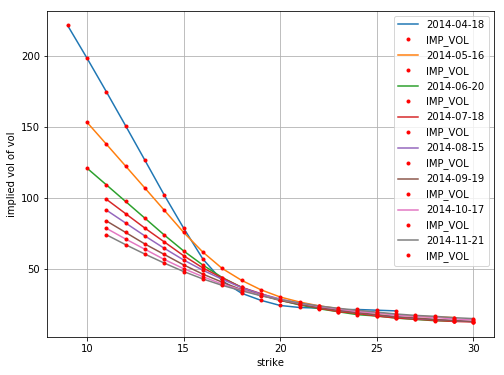

In [23]:
plt.figure(figsize=(8,6))

for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw =1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
    
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied vol of vol')
plt.legend()
plt.show()

In [26]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data.sum().head()

PRICE     IMP_VOL
MATURITY   STRIKE                   
2014-04-18 9.0      8.85  221.495807
           10.0     7.85  198.601511
           11.0     6.85  175.023232
           12.0     5.85  151.017473
           13.0     4.85  126.742226

#### Comments and Thoughts

This was mostly review in terms of pandas and matplotlib functionality.
The financial equations are new and I have no intuition for them yet. Also
the data aquisition, gathering part of h